In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing  import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_32/adp32_p1.csv')
df.head()

,date,Kwh,LaCR,LeCR,co2,LaF,LeF
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0


In [6]:

df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y %H:%M')

# 1) Month 
df['month'] = df['date'].dt.month 

# 2) dayofweek : 0- 월요일 >> 1 / 6-일요일 >> 1 
df['day'] = (df['date'].dt.dayofweek + 1 ) % 7 

# 3) nsd 
df['nsd'] = df['date'].dt.minute + (df['date'].dt.hour * 60)

In [7]:
## 파생변수 만들기 
df['ind11'] = (((df['month'] + df['day'] + df['nsd']) % 11 == 0) & 
              ((df['month'] + df['day'] + df['nsd']) % 22 != 0)).astype(int)

In [8]:
df['ind22'] = ((df['month'] + df['day'] + df['nsd']) % 22 == 0).astype(int)

In [9]:
## 파생변수 kwh8 : 4.1 초과인 경우, 1 
df['Kwh8']= df['Kwh'].map(lambda x : 1 if x > 4.1 else 0)

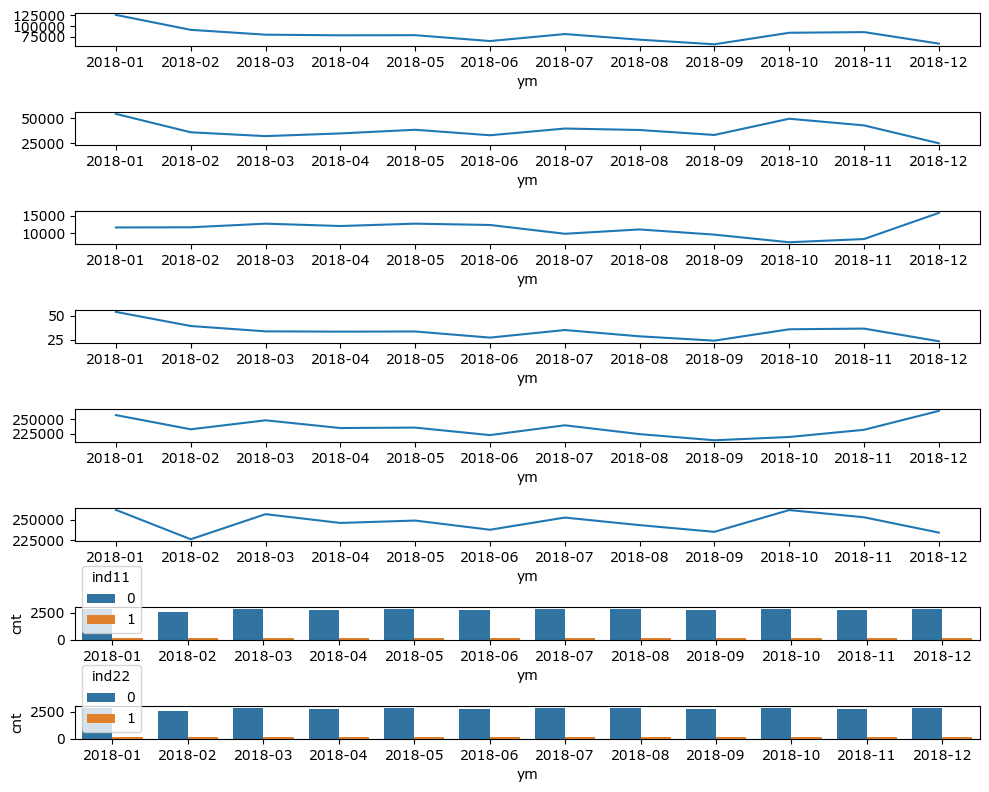

In [10]:
## Date을 year-month로 변환하기 - strftime 
p_df = df.copy()

p_df['ym'] = p_df['date'].dt.strftime('%Y-%m') 

plot_cols = ['Kwh', 'LaCR', 'LeCR', 'co2', 'LaF', 'LeF' , 'ind11' ,'ind22','ym']

fig, axes = plt.subplots(8,1, figsize = (10, 8))

for i, col in zip(axes.flatten() , plot_cols) : 
    if col not in ['ind11','ind22'] : 
        target = p_df.groupby('ym')[col].sum()
        sns.lineplot(x = target.index, y = target.values, ax = i)

    else : 
        target = p_df.groupby(['ym', col]).size().reset_index(name = 'cnt')
        sns.barplot(x = target.ym, y = target.cnt , hue = target[col], ax = i)

plt.tight_layout()
plt.show()

Kwh8를 종속 변수로 하여(Kwh제거) 분류 모델을 학습하고 평가
서포트벡터머신과 랜덤포레스트를 사용하라. confusionmatrix를 해석
1. 파생변수 ind11칼럼의 값이 1인 데이터만 훈련에 사용할 것,ind22칼럼의 값이 1인 데이터만 테스트에 사용
2. 모든 모델링은 그리드서치를 통해서 최적 파라미터를 산출할 것

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline 

In [12]:
c_df = df.drop(columns = ['date','Kwh','month','day'])

train_set = c_df[c_df['ind11'] == 1]
x_train = train_set.drop(columns = ['Kwh8'], axis = 1)
y_train = train_set['Kwh8']

test_set = c_df[c_df['ind22'] == 1]
x_test = test_set.drop(columns = ['Kwh8'], axis = 1)
y_test = test_set['Kwh8']

{'model__min_samples_leaf': 1, 'model__min_samples_split': 3, 'model__n_estimators': 10}


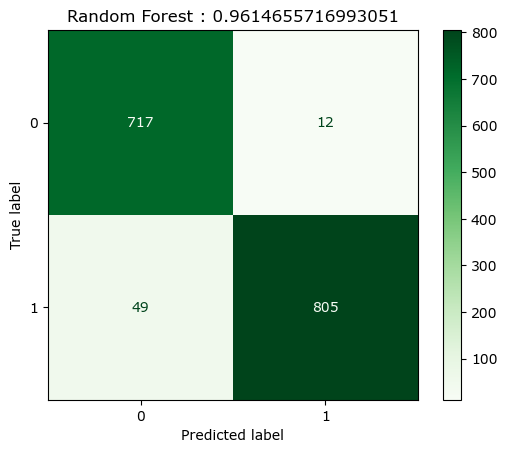

{'model__C': 1.5, 'model__kernel': 'rbf'}


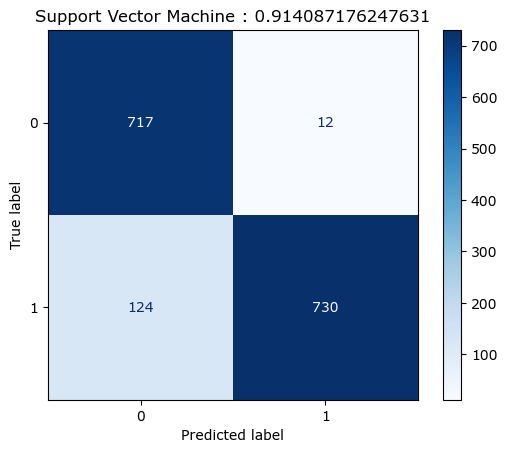

In [13]:
def classifier(name, model, x_train, y_train, x_test, y_test) : 

    # 1) Pipeline 정의 
    pipe = Pipeline([
        ('scaler' , StandardScaler()) , 
        ('model', model)
    ])
    # 2) Parameter 지정 
    if name == 'RF':
        param_grid = {
            'model__n_estimators': [1, 10, 100],
            'model__min_samples_split': [2, 3, 4],
            'model__min_samples_leaf': [1, 2]
        }
        cmap = plt.cm.Greens
        title = 'Random Forest'

    elif name == 'SVC':
        param_grid = {
            'model__C': [0.1, 1, 1.5, 2.0],
            'model__kernel': ['rbf', 'linear']
        }
        cmap = plt.cm.Blues
        title = 'Support Vector Machine'

    # 3) Grid Search 
    grid = GridSearchCV(pipe, param_grid, cv = 3, scoring = 'accuracy') 
    grid.fit(x_train, y_train)
    print(grid.best_params_)

    best_model = grid.best_estimator_
    best_pred = best_model.predict(x_test)
    score = accuracy_score(y_test, best_pred)

    cm = confusion_matrix(y_test, best_pred)
    display = ConfusionMatrixDisplay(confusion_matrix = cm)
    display.plot(cmap = cmap)
    plt.title(f'{title} : {score}')
    plt.show()

    return best_model, score 


res = []
for name, model in [['RF', RandomForestClassifier()] , ['SVC' , SVC()]] : 
    best_model, score = classifier(name, model, x_train, y_train, x_test, y_test)
    res.append([name, score])
        
        
    

1-6. Kwh를 종속변수로 회귀모델 
* 서포트벡터머신, 랜덤포레스트 사용 

In [14]:
df2 = df.drop(columns = ['date','Kwh8','month','day'])

train_set = df2[df2['ind11'] == 1]
x_train = train_set.drop(columns = ['Kwh'], axis = 1)
y_train = train_set['Kwh']

test_set = df2[df2['ind22'] == 1]
x_test = test_set.drop(columns = ['Kwh'], axis = 1)
y_test = test_set['Kwh']

Best Params: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__n_estimators': 50}
Random Forest Regression - MSE: 7.1073, R²: 0.9935


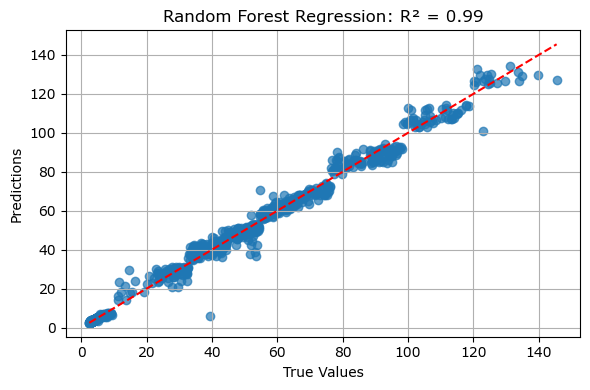

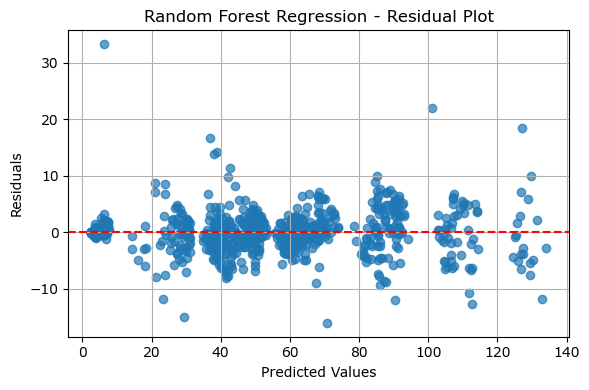

Best Params: {'model__C': 10, 'model__epsilon': 0.2, 'model__kernel': 'rbf'}
Support Vector Regression - MSE: 115.4544, R²: 0.8945


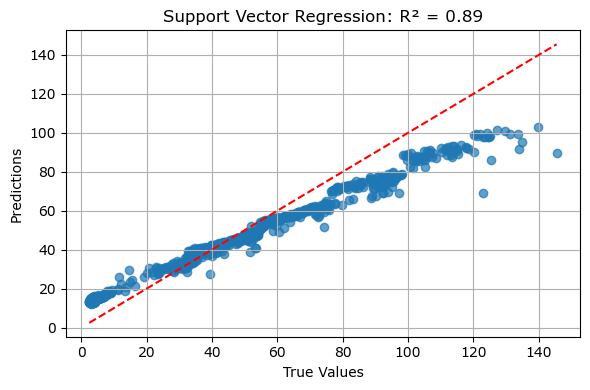

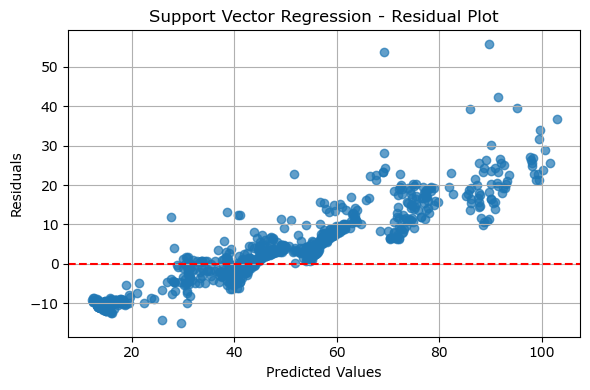

In [15]:
def regressor(name, model, x_train, y_train, x_test, y_test) : 

    # 1. pipeline 
    pipe = Pipeline([
        ('scaler' , StandardScaler()) , 
        ('model', model)
    ])

     # 모델별 파라미터
    if name == 'SVR':
        param_grid = {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['rbf', 'linear'],
            'model__epsilon': [0.1, 0.2]
        }
        title = 'Support Vector Regression'

    elif name == 'RF':
        param_grid = {
            'model__n_estimators': [50, 100],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_leaf': [1, 2]
        }
        title = 'Random Forest Regression'

    # GridSearchCV
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid.fit(x_train, y_train)
    print("Best Params:", grid.best_params_)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(x_test)

    # 평가 지표
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{title} - MSE: {mse:.4f}, R²: {r2:.4f}")

    # 시각화 1: 실제 vs 예측
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title(f'{title}: R² = {r2:.2f}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 시각화 2: 잔차
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f'{title} - Residual Plot')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return best_model, r2

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

results = []

for name, model in [['RF', RandomForestRegressor()], ['SVR', SVR()]]:
    best_model, r2 = regressor(name, model, x_train, y_train, x_test, y_test)
    results.append([name, r2])   

### 머신러닝_2

In [16]:
p = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_32/adp32_p2.csv')
p.head()

,발전기명,일자,설비용량,0시,1시,2시,3시,4시,5시,6시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,a,2020-01-01,263.225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,93.280,53.840,21.630,5.690,4.610,4.270,1.330,0.530,0.0,0.0
1,b,2020-01-01,245.725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,88.250,51.059,22.283,5.244,4.183,3.848,1.290,0.564,0.0,0.0
2,c,2020-01-01,254.425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,90.641,50.344,22.072,5.652,4.495,4.089,1.240,0.526,0.0,0.0
3,d,2020-01-01,250.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,86.995,51.953,21.831,6.149,4.666,4.141,1.228,0.491,0.0,0.0
4,a,2020-01-02,263.225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.000,25.860,8.310,4.090,0.730,1.070,0.390,0.020,0.0,0.0


In [17]:
w = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_32/adp32_p2_sub.csv')
w.head()

,일시,기온,강수량(mm),습도,적설(cm),전운량(10분위),일조(hr),일사량
0,2020-01-01 00:00,2.4,NaN,63.0,0.0,9,0.0,0.0
1,2020-01-01 01:00,2.6,0.0,63.0,0.0,9,0.0,0.0
2,2020-01-01 02:00,2.7,0.0,68.0,0.0,9,0.0,0.0
3,2020-01-01 03:00,3.2,0.0,69.0,0.0,9,0.0,0.0
4,2020-01-01 04:00,3.0,0.0,65.0,0.0,9,NaN,0.0


In [18]:
# p 데이터 피벗팅 및 전처리 
pivot_p = p.melt(id_vars = ['발전기명','일자','설비용량'], var_name = '시간' , value_name = '발전용량')

pivot_p['date'] = pd.to_datetime(
pivot_p['일자'].astype(str) + ' ' + pivot_p['시간'].str.split('시').str[0].str.zfill(2)
)

final_p = pivot_p[['date','발전기명','설비용량','발전용량']]
final_p

,date,발전기명,설비용량,발전용량
0,2020-01-01 00:00:00,a,263.225,0.0
1,2020-01-01 00:00:00,b,245.725,0.0
2,2020-01-01 00:00:00,c,254.425,0.0
3,2020-01-01 00:00:00,d,250.125,0.0
4,2020-01-02 00:00:00,a,263.225,0.0
...,...,...,...,...
105115,2022-12-30 23:00:00,d,384.021,0.0
105116,2022-12-31 23:00:00,a,368.121,0.0
105117,2022-12-31 23:00:00,b,379.121,0.0
105118,2022-12-31 23:00:00,c,364.021,0.0


In [19]:
# w 데이터 전처리
# 컬럼 정리 
w.columns = [col.split('(')[0] for col in w.columns]

# 1) 강수량, 일조량 = 0. 
w['강수량'] = w['강수량'].fillna(0)
w['일조'] = w['일조'].fillna(0)

# 2) 기온 : 직전시간 + 직후 시간의 평균으로 대치 
w['기온'] = w['기온'].combine_first((w['기온'].fillna(method = 'bfill') + 
                                  w['기온'].fillna(method = 'ffill')) / 2)

# 3) 일시 - 타입 변경 
w['일시'] = pd.to_datetime(w['일시'])

In [20]:
# Merge 
m_df = pd.merge(final_p , w , how ='left' , left_on = 'date', right_on ='일시')
m_df = m_df[m_df.columns.difference(['일시'])]

#### 2-2. 전처리 데이터를 기준으로 아래 조건으로 train,test 데이터를 나눈다. 데이터 분리 후 train 데이터의 기초 통계량을 확인하라

1. a발전기의 12시~18시의 데이터만 모델링에 사용한다.
2. 2020년도, 2021년도는 train, 2022년도는 test 데이터로 사용한다


In [21]:
import warnings
warnings.filterwarnings('ignore')
# 1. 추출 
model_df = m_df[(m_df['발전기명'] =='a') & (m_df['date'].dt.hour.isin(range(12,19)))].reset_index(drop = True) 

# 2. 구분 
train_set = model_df[model_df['date'].dt.year.isin([2020,2021])]
test_set = model_df[model_df['date'].dt.year.isin([2022])]

# Train의 기초 통계량 
print(train_set.iloc[:,1:].describe()) 

#plt.figure(figsize = (10,5))
#train_set.iloc[:,1:].plot(kind = 'box')

               강수량           기온         발전용량         설비용량           습도  \
count  5110.000000  5110.000000  5110.000000  5110.000000  5110.000000   
mean      0.206419    18.723386    78.277661   290.191007    65.166928   
std       1.762871     7.671290    67.321926    14.075334    15.126223   
min       0.000000    -2.000000     0.030000   263.225000    14.000000   
25%       0.000000    12.800000    17.890000   282.355000    54.000000   
50%       0.000000    19.100000    58.860000   289.698500    65.000000   
75%       0.000000    24.700000   131.525000   299.697000    76.000000   
max      74.600000    35.600000   247.560000   318.119000   100.000000   

               일사량           일조           적설          전운량  
count  5110.000000  5110.000000  5110.000000  5110.000000  
mean      1.413086     0.497162     0.027926     5.985519  
std       1.054632     0.440233     0.392822     3.686239  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.470000     0.000000  

#### 2.3 Train세트에서의 발전량과 나머지 변수간의 상관관계를 확인 

In [22]:
cor_df = train_set.drop(columns = ['date','발전기명'], axis = 1)
cor_df.corr()['발전용량']

강수량    -0.099701
기온      0.117670
발전용량    1.000000
설비용량   -0.020767
습도     -0.383281
일사량     0.857487
일조      0.598131
적설     -0.067622
전운량    -0.484490
Name: 발전용량, dtype: float64

In [23]:
from scipy.stats import pearsonr
# 귀무가설 : 발전용량과 변수와는 상관관계가 없다 (상관계수 p = 0)
# 대립가설 : 발전용량과 변수와는 상관관계가 있다. 
# pearson : 선형성 강도 
# spearman : 순위기반 계산 > 정규성, 선형성 가정 없음 - 비선형 단조일때 

res = []
for col in cor_df.columns.difference(['발전용량']) : 
    cor, p_val = pearsonr(cor_df['발전용량'] , cor_df[col])

    if p_val < 0.05 : 
        decision = "귀무가설기각(상관관계가 있다)"
    else : 
        decision = '귀무가설채택(상관관계가 없다)'

    res.append({
        '변수' : col, 
        'cor' : cor,
        'p_value' : p_val ,
        'decision' : decision
    })

pd.DataFrame(res)

,변수,cor,p_value,decision
0,강수량,-0.099701,9.122820e-13,귀무가설기각(상관관계가 있다)
1,기온,0.117670,3.205878e-17,귀무가설기각(상관관계가 있다)
2,설비용량,-0.020767,1.377274e-01,귀무가설채택(상관관계가 없다)
3,습도,-0.383281,1.706502e-178,귀무가설기각(상관관계가 있다)
4,일사량,0.857487,0.000000e+00,귀무가설기각(상관관계가 있다)
5,일조,0.598131,0.000000e+00,귀무가설기각(상관관계가 있다)
6,적설,-0.067622,1.309692e-06,귀무가설기각(상관관계가 있다)
7,전운량,-0.484490,4.206123e-299,귀무가설기각(상관관계가 있다)


#### 2-4 발전량을 종속변수로 하여 2개의 회귀모델링을 진행하고 모델을 평가하라

In [24]:

x_train = train_set.drop(columns = ['date','발전기명','발전용량'])
y_train = train_set['발전용량']

x_test = test_set.drop(columns = ['date','발전기명','발전용량'])
y_test = test_set['발전용량']

,Model,MSE,R2_score
0,RF,35.726040,0.764815
1,LC,36.738638,0.751294


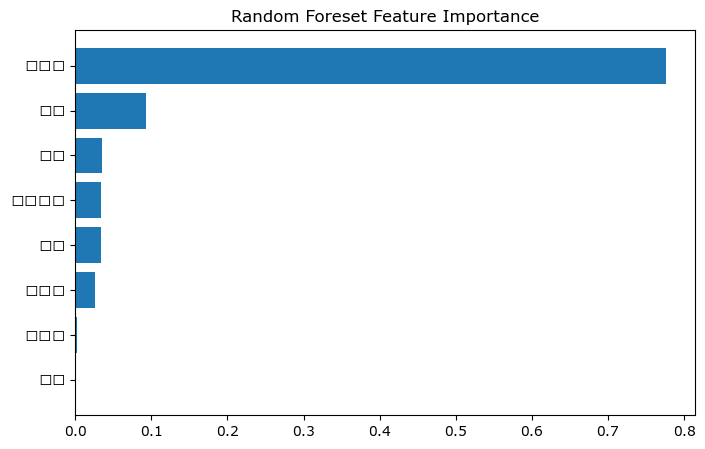

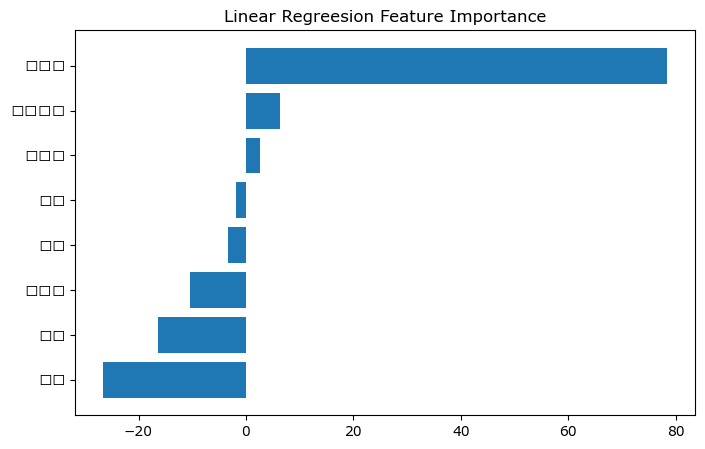

In [25]:

def regressor(name, model, x_train, y_train, x_test, y_test) :

    # 1. pipe for standardscaler()
    pipe = Pipeline([
        ('scaler', StandardScaler()) , 
        ('model', model)
    ])
    
    pipe.fit(x_train, y_train)
    pred = pipe.predict(x_test)

    # 2. 평가지표 
    mse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)

    feature_names = x_train.columns

    if name == 'RF' : 
        imp = pipe.named_steps['model'].feature_importances_ 
        title = "Random Foreset Feature Importance"

    elif name =='LC' : 
        imp = pipe.named_steps['model'].coef_
        title = "Linear Regreesion Feature Importance"

    imp = pd.Series(imp, index =feature_names).sort_values()

    plt.figure(figsize = (8,5))
    plt.barh(imp.index, imp.values)
    plt.title(f'{title}')
    

    return name, mse, r2, imp 

res = []
for name, model in [['RF', RandomForestRegressor()] , ['LC', LinearRegression()]] : 
    name, mse, r2 , imp = regressor(name, model, x_train, y_train, x_test, y_test)
    res.append(
        {'Model':name,
         'MSE': mse,
         'R2_score' : r2
        })
    #print(imp)
pd.DataFrame(res)


#### 통계 - 선형회귀 기본 가정

In [26]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/dataset/ADP_32/adp32_s1.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT1,LSTAT2,MEDV
0,0.00632,18.0,2.31,0.0,0.538,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,5.0520,24.0
1,0.02731,0.0,7.07,0.0,0.469,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,9.4440,21.6
2,0.02729,0.0,7.07,0.0,0.469,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,3.8970,34.7
3,0.03237,0.0,2.18,0.0,0.458,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,2.9410,33.4
4,0.06905,0.0,2.18,0.0,0.458,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,5.4075,36.2


In [27]:
import statsmodels.api as sm 

X = df.drop('MEDV', axis = 1)
y = df['MEDV']

add_x = sm.add_constant(X)
model = sm.OLS(y, add_x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     87.03
Date:                Sun, 06 Jul 2025   Prob (F-statistic):          2.09e-118
Time:                        18:36:31   Log-Likelihood:                -1538.2
No. Observations:                 506   AIC:                             3104.
Df Residuals:                     492   BIC:                             3164.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.4437      3.888     17.860      0.0

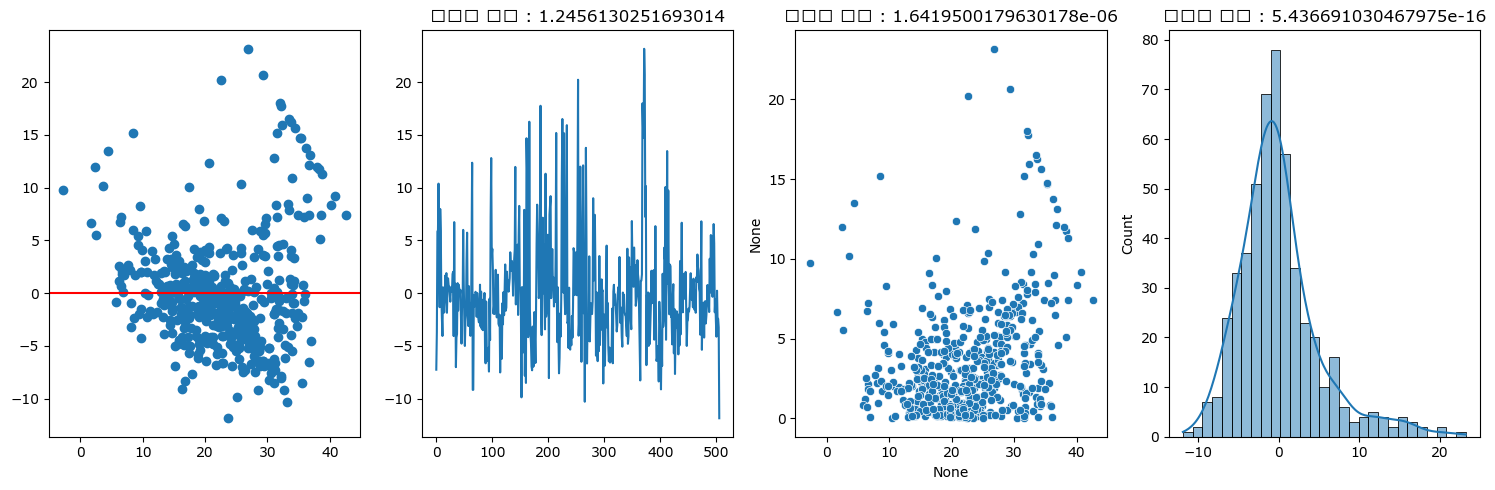

In [43]:
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
import statsmodels.stats.api as sms #등분상성 

# 예측값, 잔차
pred = model.predict(add_x)
res = model.resid

fig, axes = plt.subplots(1,4, figsize = (15,5))
# 1.선형성- 잔차와 예측값
# 독립변수와 종속변수가 선형관계 
# 잔차와 예측값의 산점도 : 잔차가 무작위로 분포하면 선형성 충족
axes[0].scatter(pred, res)
axes[0].axhline(0, color = 'red')

# 2.독립성 - 오차항끼리는 상관이 없다. 
# 더빈왓은 2 - 독립 / 2보다 작으면 양의 상관 / 2보다 크면 음의 자기 상관
dw = durbin_watson(res)  #잔차 검정 
axes[1].plot(res.values)
axes[1].set_title(f'독립성 검정 : {dw}')

# 3.등분산성 - 잔차의 분산은 일정하다. [예측값, 잔차의 절대값]
# p_val > 0.05 : 등분산 만족
bp = sms.het_breuschpagan(res, add_x)
p_val = bp[1]
sns.scatterplot(x = pred, y = np.abs(res), ax = axes[2])
axes[2].set_title(f'등분산 검정 : {p_val}')

# 4. 정규성 - 잔차의 정규 분포 
stat, p_val = shapiro(res)
sns.histplot(res, kde = True, ax= axes[3])
axes[3].set_title(f'정규성 검정 : {p_val}')

plt.tight_layout()
plt.show()


# 실제값 vs 예측값 (모델 성능 시각화)